In [ ]:
!pip install datasets

In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset('maartengr/arxiv_nlp')['train']


In [5]:
# extracting Abstracts and Titles in the respective variables
abstracts = dataset['Abstracts']
titles = dataset['Titles']

# Text Clustering

In [6]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [7]:
embeddings.shape

(44949, 384)

### Reducing the dimensionality of embeddings

In [8]:
from umap import UMAP

umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)

reduced_embeddings = umap_model.fit_transform(embeddings)

In [9]:
reduced_embeddings.shape

(44949, 5)

In [10]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean',
    cluster_selection_method='eom'
)

hdbscan_model.fit(reduced_embeddings)

HDBSCAN(min_cluster_size=50)

In [11]:
clusters = hdbscan_model.labels_

In [12]:
len(set(clusters))

156

## Inspecting the Clusters

In [13]:
import numpy as np

cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[index][:300] + "....... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo....... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang....... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf....... 



In [14]:
import pandas as pd

reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine',
    random_state=42
).fit_transform(embeddings)

df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df['title'] = titles
df['cluster'] = [str(c) for c in clusters]


# outliers and non-outliers
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

In [15]:
clusters_df = to_plot
outliers_df = outliers

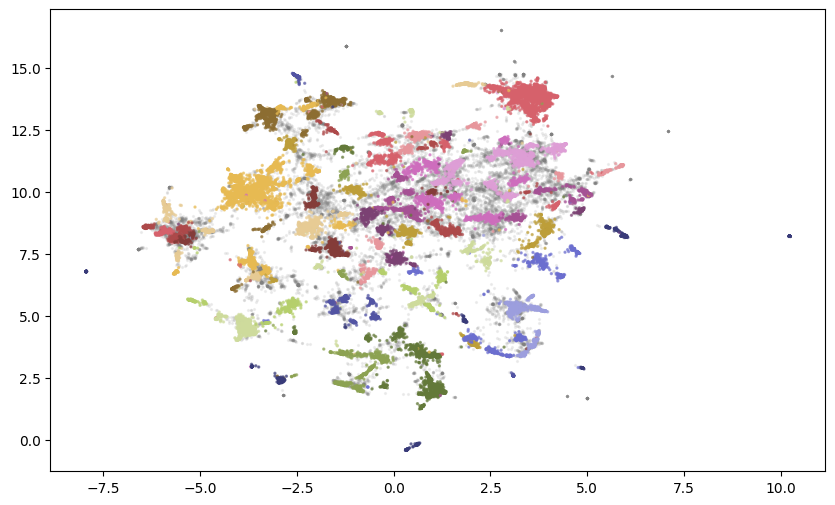

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.1, s=2, c='grey')
plt.scatter(clusters_df.x, clusters_df.y,
             c=clusters_df.cluster.astype(int),
             alpha=0.6, s=2, cmap='tab20b')


# From Text Clustering to Topic Modeling

In [ ]:
!pip install bertopic

In [19]:
from bertopic import BERTopic

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-03-23 10:04:40,224 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-23 10:05:53,831 - BERTopic - Dimensionality - Completed ✓
2025-03-23 10:05:53,834 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-23 10:05:56,163 - BERTopic - Cluster - Completed ✓
2025-03-23 10:05:56,181 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-23 10:06:00,037 - BERTopic - Representation - Completed ✓


In [21]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14989                               -1_the_of_and_to   
1        0   2165                 0_question_questions_answer_qa   
2        1   2099                   1_speech_asr_recognition_end   
3        2    905  2_summarization_summaries_summary_abstractive   
4        3    834              3_hate_offensive_speech_detection   
..     ...    ...                                            ...   
151    150     53            150_gans_gan_adversarial_generation   
152    151     52                151_recipes_recipe_cooking_food   
153    152     51                152_moe_experts_mixture_routing   
154    153     50    153_opinion_reviews_summaries_summarization   
155    154     50          154_sentence_embeddings_sts_embedding   

                                        Representation  \
0    [the, of, and, to, in, we, for, language, that...   
1    [question, questions, answer, qa, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [summarization, summaries, summary, abstractiv...   
4    [hate, offensive, speech, detection, toxic, so...   
..                                                 ...   
151  [gans, gan, adversarial, generation, generativ...   
152  [recipes, recipe, cooking, food, ingredients, ...   
153  [moe, experts, mixture, routing, expert, spars...   
154  [opinion, reviews, summaries, summarization, r...   
155  [sentence, embeddings, sts, embedding, similar...   

                                   Representative_Docs  
0    [  This paper describes our system developed f...  
1    [  The ability to ask questions is important i...  
2    [  Training state-of-the-art Automated Speech ...  
3    [  Document summarization provides an instrume...  
4    [  Current research on hate speech analysis is...  
..                                                 ...  
151  [  Text generation is of particular interest i...  
152  [  Decoding the core of procedural texts, exem...  
153  [  The Mixture of Experts (MoE) models are an ...  
154  [  When faced with a large number of product r...  
155  [  Sentence representation at the semantic lev...  

[156 rows x 5 columns]

In [24]:
topic_model.get_topic(2)

[('summarization', np.float64(0.040929863607635106)),
 ('summaries', np.float64(0.024575249415152853)),
 ('summary', np.float64(0.020668287075337112)),
 ('abstractive', np.float64(0.01807910099483175)),
 ('document', np.float64(0.01421593443881975)),
 ('extractive', np.float64(0.01109165059679254)),
 ('rouge', np.float64(0.010234766991892422)),
 ('documents', np.float64(0.006796151503686916)),
 ('evaluation', np.float64(0.006661845011703441)),
 ('factual', np.float64(0.006584651979830627))]

In [34]:
topic_model.find_topics('music')

([69, 19, 44, -1, 31],
 [np.float32(0.85526943),
  np.float32(0.812994),
  np.float32(0.8102609),
  np.float32(0.8044057),
  np.float32(0.8032633)])

In [35]:
topic_model.get_topic(69)

[('poetry', np.float64(0.051516616491739164)),
 ('lyrics', np.float64(0.04060468861779128)),
 ('music', np.float64(0.030548151306691536)),
 ('poems', np.float64(0.030211725390853816)),
 ('poem', np.float64(0.018295130066778614)),
 ('song', np.float64(0.01667315195856725)),
 ('generation', np.float64(0.012592639782505403)),
 ('poetic', np.float64(0.011645637053779925)),
 ('lyric', np.float64(0.011390054134466804)),
 ('chinese', np.float64(0.010876818356145849))]

In [36]:
topic_model.topics_[titles.index("BERTopic: Neural topic modeling with a class-based TF-IDF procedure")]

25

In [43]:
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

fig.update_layout(font=dict(size=16))

In [50]:
from copy import deepcopy

original_topics = deepcopy(topic_model.topic_representations_)

In [81]:
def topic_differences(model, original_topics, nr_topics=10):
  df = pd.DataFrame(columns=['Topic', 'Original', 'Updated'])
  for topic in range(nr_topics):
    original = original_topics[topic]
    updated = model.get_topic(topic)

    og_words = " | ".join([word for word, _ in original])
    new_words = " | ".join([word for word, _ in updated])

    df.loc[len(df)] = [topic, og_words, new_words]

  return df

Using KeyBERTInspired to update the topic_model. This extracts the keyword from the each abstracts

In [49]:
from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts,
                          representation_model)

In [82]:
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0  question | questions | answer | qa | answering...   
1      1  speech | asr | recognition | end | acoustic | ...   
2      2  summarization | summaries | summary | abstract...   
3      3  hate | offensive | speech | detection | toxic ...   
4      4  gender | bias | biases | debiasing | fairness ...   
5      5  relation | extraction | re | relations | entit...   
6      6  translation | nmt | machine | neural | bleu | ...   
7      7  ner | entity | named | recognition | entities ...   
8      8  agents | agent | game | games | environment | ...   
9      9  image | visual | vision | captioning | multimo...   

                                             Updated  
0  question | questions | answer | qa | answering...  
1  speech | asr | recognition | end | acoustic | ...  
2  summarization | summaries | summary | abstract...  
3  hate | offensive | speech | detection | toxic ...  
4  gender | bias | biases | debiasing | fairness ...  
5  relation | extraction | re | relations | entit...  
6  translation | nmt | machine | neural | bleu | ...  
7  ner | entity | named | recognition | entities ...  
8  agents | agent | game | games | environment | ...  
9  image | visual | vision | captioning | multimo...

Removing the redundancy using **Maximal Marginal Relevance**

In [83]:
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts,
                          representation_model=representation_model)

In [84]:
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0  question | questions | answer | qa | answering...   
1      1  speech | asr | recognition | end | acoustic | ...   
2      2  summarization | summaries | summary | abstract...   
3      3  hate | offensive | speech | detection | toxic ...   
4      4  gender | bias | biases | debiasing | fairness ...   
5      5  relation | extraction | re | relations | entit...   
6      6  translation | nmt | machine | neural | bleu | ...   
7      7  ner | entity | named | recognition | entities ...   
8      8  agents | agent | game | games | environment | ...   
9      9  image | visual | vision | captioning | multimo...   

                                             Updated  
0  questions | retrieval | comprehension | passag...  
1  speech | asr | audio | automatic | model | tra...  
2  summarization | summaries | abstractive | docu...  
3  hate | offensive | toxic | abusive | hateful |...  
4  gender | bias | biases | debiasing | fairness ...  
5  relation | extraction | relations | entities |...  
6  translation | nmt | neural | multilingual | pa...  
7  ner | recognition | entities | data | datasets...  
8  agents | game | planning | language | environm...  
9  visual | captioning | multimodal | captions | ...

Using Generative Models..

In [85]:
from transformers import pipeline
from bertopic.representation import TextGeneration

In [86]:
prompt = """I have a topic that contains the following documents:
        [DOCUMENTS]

        The topic is described by the following keywords: '[KEYWORDS]'.

        Based on the documents and keywords, what is the topic about?"""

generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50,
    tokenizer='whitespace'
)

topic_model.update_topics(abstracts,
                          representation_model=representation_model)


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
100%|██████████| 156/156 [00:14<00:00, 10.46it/s]


In [87]:
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0  question | questions | answer | qa | answering...   
1      1  speech | asr | recognition | end | acoustic | ...   
2      2  summarization | summaries | summary | abstract...   
3      3  hate | offensive | speech | detection | toxic ...   
4      4  gender | bias | biases | debiasing | fairness ...   
5      5  relation | extraction | re | relations | entit...   
6      6  translation | nmt | machine | neural | bleu | ...   
7      7  ner | entity | named | recognition | entities ...   
8      8  agents | agent | game | games | environment | ...   
9      9  image | visual | vision | captioning | multimo...   

                                             Updated  
0      Question answering |  |  |  |  |  |  |  |  |   
1  Speech-to-speech comparison metric |  |  |  | ...  
2  Document summarization |  |  |  |  |  |  |  |  |   
3    hate speech analysis |  |  |  |  |  |  |  |  |   
4             gender bias |  |  |  |  |  |  |  |  |   
5     Relation extraction |  |  |  |  |  |  |  |  |   
6  Neural machine translation |  |  |  |  |  |  |...  
7  Named entity recognition |  |  |  |  |  |  |  ...  
8                    game |  |  |  |  |  |  |  |  |   
9  Image, visual, visual, visual, visual, visual,...